# ライブラリ

In [1]:
# !pip install librosa
# !pip install tqdm
# !pip install pycm


In [2]:
#ライブラリのインポート 
import librosa
import os
import matplotlib.pyplot as plt
import numpy as np
import IPython.display
import pandas as pd
import statistics as sta
import torch
import torch.nn as nn
import torch.nn.functional as F

print(librosa.__version__)
print(torch.__version__)

#ライブラリ
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import LabelEncoder

# t-SNE 特徴量空間上での可視化
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from numpy.random import default_rng
rng = default_rng(0)

from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set() # グラフ描画用
from sklearn.metrics import classification_report

import pandas as pd

from pycm import ConfusionMatrix

import csv

0.10.2.post1
2.2.2


# データセットの作成

In [3]:
sr = 44100 #サンプリング周波数

## 試行ごとに分割

In [4]:


# #ファイルパスの指定
# origin_data = "data/origin_data/origindata_20240619"

# #学習用データの読み込み
# audio_dir = origin_data
# subFolders = [f for f in os.listdir(audio_dir) if os.path.isdir(os.path.join(audio_dir, f))]
# subFolders = sorted(subFolders) #昇順に並び替え

# #ファイル読み込み
# # originDatasに音声データを格納していく
# originDatas = []
# for subFolder in subFolders:
#     filePath = audio_dir+"/"+subFolder+"/"+subFolder+".WAV"
#     originData, sr = librosa.load(filePath, sr = sr)
#     originDatas.append(originData)
#     print(subFolder)
# #1データから30試行をトリミングを22パターン分行い，soundDataset_new_newに格納する
# # soundDataset_new_newの構造：[パターン(10)][試行(50)][サンプリングデータ(66150)]

# flag_amp = 0.1 #各試行の合図を検知する基準振幅
# trimSkip = int(sr*0.4)
# trimTime = int(sr*1.5)#1試行あたりのデータ長
# dataNum = 50
# trial = 0
# soundDataset_new =([])

# while trial <len(originDatas):
#     index = 0
#     trimDatas = ([]) #1データ(30試行)分のトリミングデータのリストを初期化
#     originData = np.array(originDatas[trial])
#     while index <len(originData):
#         if originData[index] >= flag_amp:
#             trimData = np.array(originData[index+trimSkip:index+trimTime+trimSkip]) #trim_dataにそのindexからindex+trimTimeのデータを格納する
#             trimDatas = np.append(trimDatas ,trimData, axis=0)  #trimDatasに追加する
#             index += trimTime
#         else:
#             index +=1
#         if len(trimDatas) >=dataNum*trimTime:
#             break
#     soundDataset_new = np.append(soundDataset_new,np.array(trimDatas),axis=0)
#     trial += 1

# soundDataset_new = soundDataset_new.reshape(len(originDatas),dataNum,trimTime)

# print(soundDataset_new.shape)

# import pickle
# f = open('soundDataset_20240619.pickle','wb')
# pickle.dump(soundDataset_new,f)

## ラベルを含んだデータセット化

In [5]:
import pickle
f = open('soundDataset_20240619.pickle','rb')
soundDataset_new = pickle.load(f)

patterns = soundDataset_new.shape[0] #物体の種類
trials = soundDataset_new.shape[1] #試行数
len_data = soundDataset_new.shape[2] #1試行の長さ,サンプル数
num_data = patterns*trials #全試行数

print(patterns,trials,len_data,num_data)

21 50 66150 1050


### ラベルのリスト

In [6]:
#object層
objLabel = [
    "y-shirt", 
    "jeans", 
    "sweatshirt", 

    "blanket", 
    "bedquilt", 
    "pillow", 
       
    "mousepad", 
    "chair", 
    "sofa", 
    
    "thick-Book", 
    "thin-Book", 
    "cardboard", 

    "metal-desk", 
    "laptop", 
    "alumi-rack", 
    
    "wood-desk", 
    "wood-shelf", 
    "floor", 
    
    "pla-Case", 
    "pla-Container", 
    "pla-Shelf"
]
objNum= []

#material層
matLabel = [
    "clothing",
    "bedding", 
    "memory-foam", 
    "paper", 
    "metal", 
    "wood", 
    "plastic"
]

matNum = [0,1,2,3,4,5,6]

#soft-hard層
shLabel = [
    "soft",
    "hard",
]

shNum = [0,1]





### wavファイルの作成

In [7]:
# import soundfile as sf

# # wavファイルへの変換
# def MakeTrimData(target_num,trial):
#     # 既存のサンプル数66150の配列
#     audio_data = soundDataset_new[target_num][trial]

#     # WAVファイルに書き込む
#     output_file = 'data/trim_data/trim-data_'+str(target_num)+'_'+str(trial)+'.wav'
#     sample_rate = 44100  # サンプルレート（例: 44100 Hz）
#     sf.write(output_file, audio_data, sample_rate)

#     print(f"WAVファイル '{output_file}' に書き込みました。")

# # wavファイルへの変換実行
# for target_num in range(len(soundDataset_new)):
#     for trial in range(len(soundDataset_new[0])):
#         MakeTrimData(target_num,trial)

### データフレーム化・CSVに書き出し

In [8]:
# # num_feature次元のMFCCのデータフレームを作成

# # ファイル名の生成と追加
# filenames = []
# for target_num in range(21):
#     for trial in range(50):
#         filenames.append(f'trim-data_{target_num}_{trial}.wav')

# Dataset = pd.DataFrame()

# Dataset['filename'] = filenames
# Dataset['objectNum'] = [i // soundDataset_new.shape[1] for i in range(1050)]
# Dataset['matNum'] = np.repeat(matNum, 150)[:1050]
# Dataset['shNum'] = np.array([0]*450 + [1]*600)

# # データセットに'objLabel'の列を追加
# Dataset['object'] = np.repeat(objLabel, 50)[:1050]

# # # データセットに'matLabel'の列を追加
# Dataset['mat'] = np.repeat(matLabel, 150)[:1050]

# # # データセットに'SHLabel'の列を追加
# Dataset['sh'] = np.array(['soft']*450 + ['hard']*600)


# # データフレームをCSVファイルに保存
# csv_path = 'data/meta_data/dataset.csv'
# Dataset.to_csv(csv_path, index=False)

# # Display the DataFrame
# pd.set_option('display.max_rows', 100)


Dataset = pd.read_csv('data/meta_data/dataset.csv')
Dataset

,filename,objectNum,matNum,shNum,object,mat,sh
0,trim-data_0_0.wav,0,0,0,y-shirt,clothing,soft
1,trim-data_0_1.wav,0,0,0,y-shirt,clothing,soft
2,trim-data_0_2.wav,0,0,0,y-shirt,clothing,soft
3,trim-data_0_3.wav,0,0,0,y-shirt,clothing,soft
4,trim-data_0_4.wav,0,0,0,y-shirt,clothing,soft
...,...,...,...,...,...,...,...
1045,trim-data_20_45.wav,20,6,1,pla-Shelf,plastic,hard
1046,trim-data_20_46.wav,20,6,1,pla-Shelf,plastic,hard
1047,trim-data_20_47.wav,20,6,1,pla-Shelf,plastic,hard
1048,trim-data_20_48.wav,20,6,1,pla-Shelf,plastic,hard


### MFCCのデータセット作成

In [9]:
# 特徴量の次元数
num_feature = 40

# 空のmfccSetを初期化
mfccSet = np.empty((0, num_feature))

# ループを使用してMFCCを抽出してmfccSetに追加
for pattern in range(patterns):
    for trial in range(trials):
        # MFCCを計算
        mfccs = librosa.feature.mfcc(y=soundDataset_new[pattern][trial], sr=sr)
        # MFCCの各次元の平均を算出
        mean = mfccs.mean(axis=1)
        # MFCCの各次元の標準偏差を算出
        std = np.std(mfccs, axis=1)
        # mean, max_val, min_val, std をまとめた配列を作成
        combined_stats = np.concatenate([mean,  std])
        # mfccSetに追加
        mfccSet = np.append(mfccSet, [combined_stats], axis=0)

# 形状を確認
print(mfccSet.shape)

(1050, 40)


In [10]:
# ファイル名の生成と追加

Dataset_mfcc = pd.DataFrame(data=mfccSet)

Dataset_mfcc['objNum'] = [i // soundDataset_new.shape[1] for i in range(1050)]
Dataset_mfcc['matNum'] = np.repeat(matNum, 150)[:1050]
Dataset_mfcc['shNum'] = np.array([0]*450 + [1]*600)

# データセットに'objLabel'の列を追加
Dataset_mfcc['obj'] = np.repeat(objLabel, 50)[:1050]

# # データセットに'matLabel'の列を追加
Dataset_mfcc['mat'] = np.repeat(matLabel, 150)[:1050]

# # データセットに'SHLabel'の列を追加
Dataset_mfcc['sh'] = np.array(['soft']*450 + ['hard']*600)


# データフレームをCSVファイルに保存
# csv_path = 'data/meta_data/dataset_vib_mfcc.csv'
# Dataset_mfcc.to_csv(csv_path, index=True)

# Display the DataFrame
pd.set_option('display.max_rows',100)

Dataset_mfcc

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,objNum,matNum,shNum,obj,mat,sh
0,-478.001703,63.457280,36.144773,26.225528,16.727231,14.407245,13.285984,9.590793,9.811856,5.082892,...,3.645248,3.399917,3.804335,3.734329,0,0,0,y-shirt,clothing,soft
1,-476.196495,67.811489,42.117584,28.188400,15.583791,13.266734,12.080886,8.774526,8.174143,4.179097,...,3.640349,3.322606,3.285746,3.343535,0,0,0,y-shirt,clothing,soft
2,-477.773147,65.936731,41.942033,28.753131,17.348440,16.986556,15.279845,11.019433,9.088018,5.031381,...,3.156580,3.407280,3.517655,3.547526,0,0,0,y-shirt,clothing,soft
3,-482.200915,63.764375,39.955530,26.105635,15.753873,13.904783,13.131842,9.218075,7.482949,4.541441,...,3.725960,3.272637,3.092343,3.604951,0,0,0,y-shirt,clothing,soft
4,-479.097029,65.641729,40.932618,27.617450,16.556075,14.817480,14.321870,10.350258,8.893235,4.703604,...,3.328177,3.571923,3.805326,4.301650,0,0,0,y-shirt,clothing,soft
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,-462.453427,78.334440,45.349090,29.702114,15.009005,12.011045,13.299042,9.038196,6.716250,1.844909,...,3.297809,3.660277,3.493659,4.016997,20,6,1,pla-Shelf,plastic,hard
1046,-462.308041,79.059942,46.864514,30.124729,14.844601,12.301888,14.513218,10.563808,7.084634,1.905388,...,3.441372,3.365149,3.482850,4.577083,20,6,1,pla-Shelf,plastic,hard
1047,-461.417660,80.208434,46.588974,29.178092,14.371811,11.147610,12.965775,10.084192,7.170428,2.227163,...,3.539720,3.766647,4.083665,4.772348,20,6,1,pla-Shelf,plastic,hard
1048,-464.390102,76.848395,45.564795,31.331828,17.138878,14.709765,15.806167,10.320537,7.870815,3.794003,...,3.418645,3.032147,3.479765,4.267387,20,6,1,pla-Shelf,plastic,hard


### メルスペクトログラムのデータセット

In [11]:
# パターンごとにスペクロログラムの保存
Dataset_melspec = []
trial_num = 50
for patern in range (len(soundDataset_new)):
    for trial in range(trial_num):
        trimData = soundDataset_new[patern,trial]
        spectrogram = librosa.feature.melspectrogram(y=trimData, sr=sr)# スペクトログラムを計算
        spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)    
        Dataset_melspec.append(spectrogram_db)

Dataset_melspec = np.array(Dataset_melspec)
Dataset_melspec = np.expand_dims(Dataset_melspec,1)
print(Dataset_melspec.shape)
print(type(Dataset_melspec))

(1050, 1, 128, 130)
<class 'numpy.ndarray'>


### データ分割

In [12]:
# ラベルのデータセット
Dataset_label = Dataset.iloc[:,1:4]
Dataset_label_np = Dataset_label.to_numpy()

# テンソルに変換
Dataset_melspec_tensor = torch.tensor(Dataset_melspec, dtype=torch.float32)
Dataset_label_tensor = torch.tensor(Dataset_label_np, dtype=torch.int64)

# split (stratify by the first column of labels as an example)
train_feature, eval_feature, train_labels, eval_labels = train_test_split(
    Dataset_melspec_tensor, Dataset_label_tensor, 
    stratify=Dataset_label_np[:, 0], shuffle=True, random_state=42, train_size=0.6
)

val_feature, test_feature, val_labels, test_labels = train_test_split(
    eval_feature, eval_labels, 
    stratify=eval_labels[:, 0], shuffle=True, random_state=42, train_size=0.5
)


# 評価

## t-SNEで特徴量空間の可視化

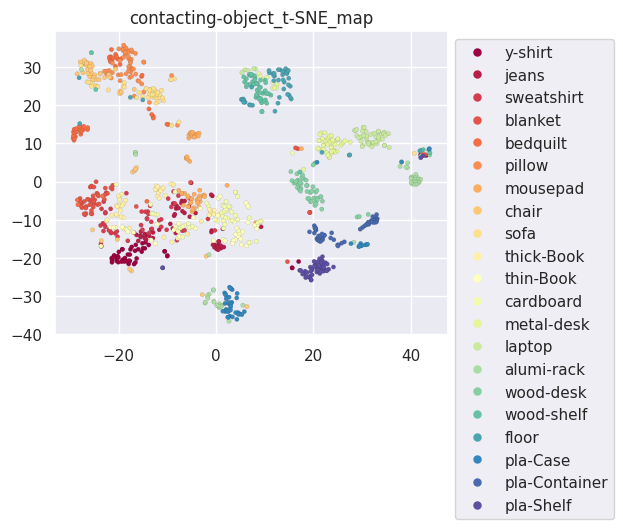

In [13]:


tsne = TSNE(
    n_components=2,
    perplexity=30.0,
    random_state=(0)
)
X_tsne = tsne.fit_transform(Dataset_mfcc.iloc[:,1:num_feature])

# プロット
title = "contacting-object_t-SNE_map"
plt.title(title)

scatter=plt.scatter(
            X_tsne[:, 0], 
            X_tsne[:, 1], 
            c=Dataset_mfcc['objNum'], 
            cmap='Spectral',
            edgecolor='black',
            linewidths=0.05,
            s=10 
        )  
# 凡例を追加
plt.legend(handles=scatter.legend_elements(num=21)[0],labels=objLabel,bbox_to_anchor=(1, 1), loc='upper left')

plt.tight_layout()

# plt.savefig("data/output_data/"+title+".pdf")

## SVMでの評価

In [14]:
def Eval_svm(subject,trainDataset,labelDataset,target,save):
    #機械学習アルゴリズムの選択
    model = svm.SVC(kernel="linear",C =0.01,random_state = 0) 

    #10分割交差検証
    folds = 10 #分割数
    stratifiedkfold = StratifiedKFold(n_splits=folds, shuffle=True, random_state=0) #10分割交差検証のパラメータ定義

    pred = cross_val_predict(model, trainDataset,labelDataset, cv=stratifiedkfold)
    
    #classification_reportの作成
    report = classification_report(labelDataset, pred,digits=3,target_names=target)
    print(report)
    
    #混同行列の作成
    cm = confusion_matrix(y_true=labelDataset,y_pred=pred)
    p = sns.heatmap(cm, square=True, cbar=True, annot=True,cmap='Blues',fmt="d",
                    label=target,
                    xticklabels=target,
                    yticklabels=target)
    title = "confusion_matrix_"+subject
    plt.title(title)
    plt.xlabel('predict')
    plt.ylabel('actual')

    #保存設定
    if save == True:
        plt.savefig('data/output_data/'+title+'.pdf', bbox_inches='tight')
        with open('data/output_data/eval_report_'+subject+'.pdf','w') as f:
            print(report)


### object層

               precision    recall  f1-score   support

      y-shirt      0.896     0.860     0.878        50
        jeans      0.833     0.800     0.816        50
   sweatshirt      0.868     0.920     0.893        50
      blanket      0.644     0.760     0.697        50
     bedquilt      0.848     0.780     0.812        50
       pillow      0.809     0.760     0.784        50
     mousepad      0.712     0.740     0.725        50
        chair      1.000     0.960     0.980        50
         sofa      0.933     0.840     0.884        50
   thick-Book      0.741     0.860     0.796        50
    thin-Book      0.792     0.840     0.816        50
    cardboard      0.887     0.940     0.913        50
   metal-desk      0.980     0.980     0.980        50
       laptop      0.961     0.980     0.970        50
   alumi-rack      0.860     0.860     0.860        50
    wood-desk      0.654     0.680     0.667        50
   wood-shelf      0.933     0.840     0.884        50
        f

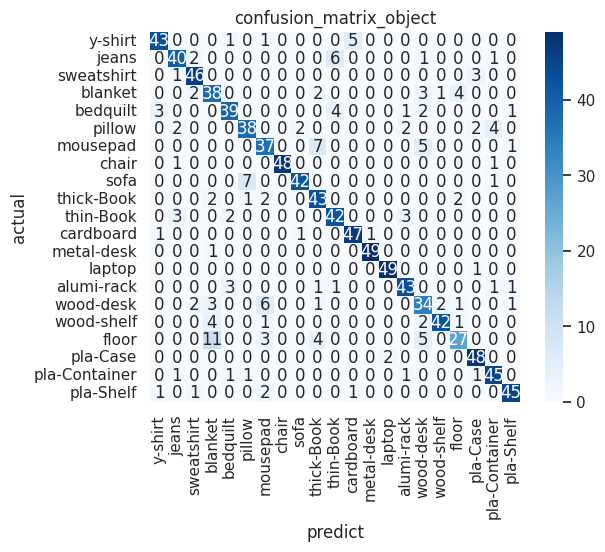

In [15]:
Eval_svm(
    "object",
    Dataset_mfcc.iloc[:,1:num_feature],
    Dataset_mfcc.obj,
    objLabel,
    False
    )

### material層

              precision    recall  f1-score   support

    clothing      0.808     0.840     0.824       150
     bedding      0.787     0.887     0.834       150
 memory-foam      0.784     0.653     0.713       150
       paper      0.943     0.880     0.910       150
       metal      0.800     0.853     0.826       150
        wood      0.929     0.960     0.944       150
     plastic      0.910     0.880     0.895       150

    accuracy                          0.850      1050
   macro avg      0.852     0.850     0.849      1050
weighted avg      0.852     0.850     0.849      1050



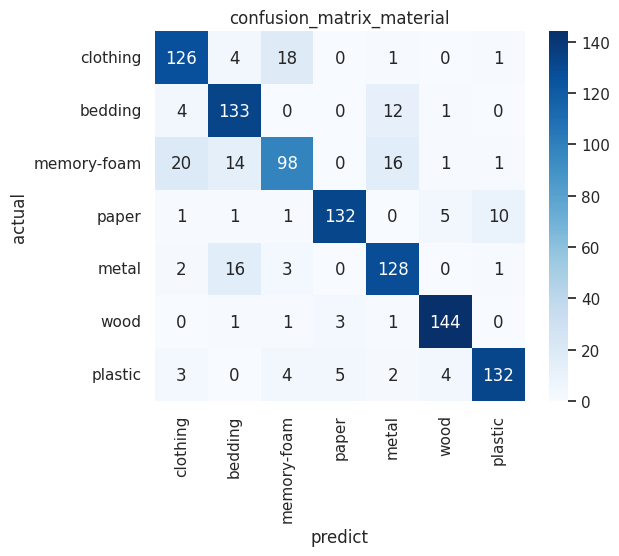

In [16]:
Eval_svm(
    "material",
    Dataset_mfcc.iloc[:,1:num_feature],
    Dataset_mfcc.mat,
    matLabel,
    False
    )

### soft-hard層

              precision    recall  f1-score   support

        soft      0.895     0.897     0.896       600
        hard      0.862     0.860     0.861       450

    accuracy                          0.881      1050
   macro avg      0.879     0.878     0.878      1050
weighted avg      0.881     0.881     0.881      1050



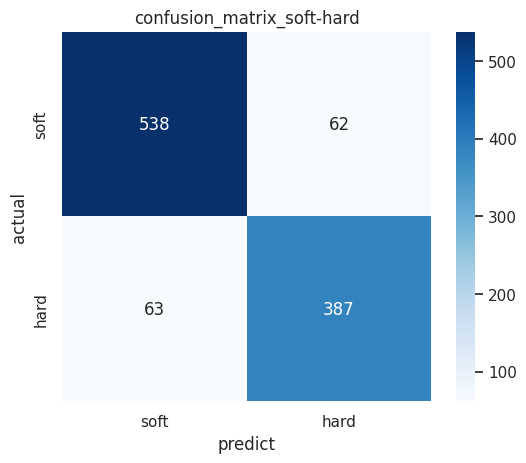

In [17]:
Eval_svm(
    "soft-hard",
    Dataset_mfcc.iloc[:,1:num_feature],
    Dataset_mfcc.sh,
    shLabel,
    False
    )

## CNNでの評価

### soft-hard 1

In [18]:

# # ラベルの指定
# t_df = Dataset.shNum

# # テンソル形式に変換
# df_tenosor = torch.tensor(Dataset_melspec, dtype=torch.float32)
# df_tenosor = torch.unsqueeze(df_tenosor, 1)
# label_tensor = torch.tensor(t_df, dtype=torch.int64)
# print(df_tenosor.size())

# # x と t を組み合わせて TensorDataset を作成
# dataset = torch.utils.data.TensorDataset(df_tenosor, label_tensor)

# # 各データセットのサンプル数を決定
# # train : val: test = 50%　: 25% : 25%
# n_train = int(len(dataset) * 0.5)
# n_val = int(len(dataset) * 0.25)
# n_test = len(dataset) - n_train - n_val
     
# # それぞれのサンプル数を確認
# print(n_train, n_val, n_test)

# # ランダムに分割を行うため、シードを固定して再現性を確保
# torch.manual_seed(0)

# # データセットの分割
# train, val, test = torch.utils.data.random_split(dataset, [n_train, n_val, n_test])

# # バッチサイズ
# batch_size = 25

      
# # shuffle はデフォルトで False のため、学習データのみ True に指定
# train_loader = torch.utils.data.DataLoader(train, batch_size, shuffle=True)
# val_loader = torch.utils.data.DataLoader(val, batch_size)
# test_loader = torch.utils.data.DataLoader(test, batch_size)

# print(train_loader)

# for batch in train_loader:
#     print(batch)

In [19]:
# tensorDatasetの作成
label_num = 2
train = torch.utils.data.TensorDataset(train_feature, train_labels[:,label_num])
val = torch.utils.data.TensorDataset(val_feature, val_labels[:,label_num])
test = torch.utils.data.TensorDataset(test_feature, test_labels[:,label_num])

# データローダに読み込む

# バッチサイズ
batch_size = 25

# shuffle はデフォルトで False のため、学習データのみ True に指定
train_loader = torch.utils.data.DataLoader(train, batch_size)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

for batch in train_loader:
    print(batch)

[tensor([[[[-18.6449, -11.7246,  -6.5343,  ..., -11.9112, -15.4409, -18.4369],
          [-14.1433,  -8.6324,  -6.4371,  ...,  -9.5212, -13.2930, -17.3637],
          [-17.4376, -17.0584, -18.9777,  ..., -17.6915, -19.0179, -18.6800],
          ...,
          [-53.1124, -51.7137, -51.1311,  ..., -51.2993, -51.5490, -53.4112],
          [-56.2612, -53.3037, -53.0943,  ..., -50.5234, -50.8584, -54.4903],
          [-55.8219, -52.3756, -51.8694,  ..., -52.8145, -52.2957, -52.7583]]],


        [[[-13.9764,  -8.9048,  -5.3486,  ...,  -0.4879,   0.0000,  -3.3279],
          [-18.0149,  -9.1427,  -5.1173,  ...,  -3.1938,  -1.3744,  -3.8136],
          [-29.0665, -17.4435, -14.8924,  ..., -16.7759, -15.4157, -12.8940],
          ...,
          [-54.9681, -50.0708, -50.2818,  ..., -50.2125, -50.9931, -53.4501],
          [-56.0666, -50.7504, -50.2297,  ..., -51.7665, -51.2975, -53.3952],
          [-53.6472, -50.9079, -52.0095,  ..., -50.7171, -50.7903, -52.6510]]],


        [[[-19.0949, -17.

In [20]:
# modelのインポート
from models.dymn.model import get_model as get_dymn
shModel = get_dymn(pretrained_name="dymn10_as")

#パラメータの更新を許可
for param in shModel.parameters():
    param.requires_gred = False


# print(model.classifier)

# 出力層の最後だけ変更
# model.classifier[5] = torch.nn.Linear(1280,2)
shModel.classifier= nn.Sequential(
    nn.AdaptiveAvgPool2d(output_size=1),
    nn.Flatten(start_dim=1, end_dim=-1),
    nn.Linear(in_features=960, out_features=1280, bias=True),
    nn.Hardswish(),
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=527, bias=True),
    nn.BatchNorm1d(527),
    nn.Linear(in_features=527, out_features=2, bias=True),  # 新しい層
)
print(shModel)

DyMN(
  (layers): ModuleList(
    (0): DY_Block(
      (exp_conv): DynamicWrapper(
        (module): Identity()
      )
      (exp_norm): Identity()
      (exp_act): DynamicWrapper(
        (module): Identity()
      )
      (depth_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (depth_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (depth_act): DyReLUB(
        (coef_net): Sequential(
          (0): Linear(in_features=32, out_features=64, bias=True)
        )
        (sigmoid): Sigmoid()
      )
      (ca): CoordAtt()
      (proj_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (proj_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (context_gen): ContextGen(
        (joint_conv): Conv2d(16, 32, kernel_size=(1, 1

/opt/conda/lib/python3.10/site-packages/torchvision/ops/misc.py:120: UserWarning: Don't use ConvNormActivation directly, please use Conv2dNormActivation and Conv3dNormActivation instead.
  warnings.warn(


In [21]:
# # !pip install torchsummary
# import torchsummary

# summary = torchsummary.summary(model, (1, 128, 130))

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

# エポックの数
epoch = 0
max_epoch = 100
     
# モデルの初期化
torch.manual_seed(0)

# GPU の設定状況に基づいたデバイスの選択
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
# モデルのインスタンス化とデバイスへの転送
net1 = shModel.cuda()

criterion = F.cross_entropy
  
# 最適化手法の選択
optimizer = torch.optim.SGD(net1.parameters(), lr=0.1)
# エポックごとの訓練データの損失と検証データの損失を保存するリスト
train_losses = []
val_losses = []

train_epoch_loss = 1
val_epoch_loss = 1
# 学習ループ
while (train_epoch_loss > 0.1 or val_epoch_loss  > 0.46) and epoch<max_epoch:
    # 訓練データでの学習
    net1.train()
    for batch in train_loader:
        x, t = batch
        x = x.to(device)        
        t = t.to(device)
        optimizer.zero_grad()
        y = net1(x)
    
        loss = criterion(y[0], t)
        train_epoch_loss += loss.item()  # エポック全体の訓練データの損失に加算
        loss.backward()
        optimizer.step()
    
    # 訓練データでのエポックごとの平均損失を計算し保存
    train_epoch_loss /= len(train_loader)
    train_losses.append(train_epoch_loss)
    
    # 検証データでの評価
    net1.eval()
    with torch.no_grad():
        for batch in val_loader:
            x, t = batch
  
            x = x.to(device)
            t = t.to(device)
            y = net1(x)
            loss = criterion(y[0], t)
            val_epoch_loss += loss.item()  # エポック全体の検証データの損失に加算
       
    # 検証データでのエポックごとの平均損失を計算し保存
    val_epoch_loss /= len(val_loader)
    val_losses.append(val_epoch_loss)
    
    # エポックごとに損失を表示
    print(f'Epoch [{epoch+1}/{max_epoch}], Train Loss: {train_epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}')
    epoch+=1
    
shModel_trained = net1


cuda:0
Epoch [1/100], Train Loss: 0.9338, Validation Loss: 106.2052
Epoch [2/100], Train Loss: 0.6548, Validation Loss: 33.0581
Epoch [3/100], Train Loss: 1.5197, Validation Loss: 7.3476
Epoch [4/100], Train Loss: 1.0423, Validation Loss: 1.8936
Epoch [5/100], Train Loss: 0.2649, Validation Loss: 0.5559
Epoch [6/100], Train Loss: 0.1477, Validation Loss: 0.5908
Epoch [7/100], Train Loss: 0.0755, Validation Loss: 0.4594


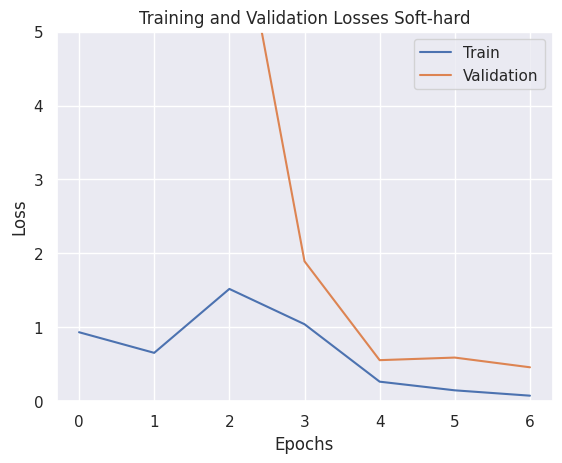

In [23]:
from datetime import datetime
import pytz
def ShowTrainLoss(train_losses,val_losses,save):
    # 日本時間のタイムゾーンを取得
    jst = pytz.timezone('Asia/Tokyo')

    # 現在の日本時間を取得
    now = datetime.now(jst)

    # 時刻を指定された形式の文字列に変換
    time = "_"+now.strftime("%Y%m%d%H%M")

    # 学習曲線の可視化

    title = 'Training and Validation Losses Soft-hard'
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0,5)
    plt.legend()
    if save == True:
        plt.savefig("data/"+title+time+".pdf")

    plt.show()

ShowTrainLoss(train_losses,val_losses,False)

In [24]:

# dim=1 で行ごとの最大値に対する要素番号を取得（dim=0 は列ごと）
y_label = torch.argmax(y[0], dim=1)
# 予測値から最大となるクラスの番号を取り出した結果
y_label
# 目的変数
t
# 値が一致しているか確認
y_label == t
# int => float 
torch.sum(y_label == t) * 1.0
# 正解率
acc = torch.sum(y_label == t) * 1.0 / len(t)
acc


# 正解率の計算
def calc_acc(data_loader):
    
    with torch.no_grad():
        
        accs = [] # 各バッチごとの結果格納用
        
        for batch in data_loader:
            x, t = batch
            
            # x = torch.unsqueeze(x,1)
            
            x = x.to(device)
            t = t.to(device)
            y = net1(x)
            
            y_label = torch.argmax(y[0], dim=1)
            acc = torch.sum(y_label == t) * 1.0 / len(t)
            accs.append(acc)
            
    # 全体の平均を算出
    avg_acc = torch.tensor(accs).mean()
    print('Accuracy: {:.1f}%'.format(avg_acc * 100))
    
    return avg_acc
      
# 検証データで確認
calc_acc(val_loader)
# テストデータで確認
calc_acc(test_loader)


Accuracy: 86.4%
Accuracy: 88.2%


tensor(0.8822)

### material 1

In [25]:
# tensorDatasetの作成
label_num = 1
train = torch.utils.data.TensorDataset(train_feature, train_labels[:,label_num])
val = torch.utils.data.TensorDataset(val_feature, val_labels[:,label_num])
test = torch.utils.data.TensorDataset(test_feature, test_labels[:,label_num])

# データローダに読み込む

# バッチサイズ
batch_size = 50

# shuffle はデフォルトで False のため、学習データのみ True に指定
train_loader = torch.utils.data.DataLoader(train, batch_size)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

for batch in train_loader:
    print(batch)

[tensor([[[[-18.6449, -11.7246,  -6.5343,  ..., -11.9112, -15.4409, -18.4369],
          [-14.1433,  -8.6324,  -6.4371,  ...,  -9.5212, -13.2930, -17.3637],
          [-17.4376, -17.0584, -18.9777,  ..., -17.6915, -19.0179, -18.6800],
          ...,
          [-53.1124, -51.7137, -51.1311,  ..., -51.2993, -51.5490, -53.4112],
          [-56.2612, -53.3037, -53.0943,  ..., -50.5234, -50.8584, -54.4903],
          [-55.8219, -52.3756, -51.8694,  ..., -52.8145, -52.2957, -52.7583]]],


        [[[-13.9764,  -8.9048,  -5.3486,  ...,  -0.4879,   0.0000,  -3.3279],
          [-18.0149,  -9.1427,  -5.1173,  ...,  -3.1938,  -1.3744,  -3.8136],
          [-29.0665, -17.4435, -14.8924,  ..., -16.7759, -15.4157, -12.8940],
          ...,
          [-54.9681, -50.0708, -50.2818,  ..., -50.2125, -50.9931, -53.4501],
          [-56.0666, -50.7504, -50.2297,  ..., -51.7665, -51.2975, -53.3952],
          [-53.6472, -50.9079, -52.0095,  ..., -50.7171, -50.7903, -52.6510]]],


        [[[-19.0949, -17.

In [26]:
matModel = shModel_trained

#パラメータの更新を許可
for param in matModel.parameters():
    param.requires_gred = False


# print(model.classifier)

# 出力層の最後だけ変更
# model.classifier[5] = torch.nn.Linear(1280,2)
matModel.classifier= nn.Sequential(
    nn.AdaptiveAvgPool2d(output_size=1),
    nn.Flatten(start_dim=1, end_dim=-1),
    nn.Linear(in_features=960, out_features=1280, bias=True),
    nn.Hardswish(),
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=527, bias=True),
    nn.ReLU(),
    nn.Linear(in_features=527, out_features=7, bias=True),  # 新しい層
)
print(matModel)

DyMN(
  (layers): ModuleList(
    (0): DY_Block(
      (exp_conv): DynamicWrapper(
        (module): Identity()
      )
      (exp_norm): Identity()
      (exp_act): DynamicWrapper(
        (module): Identity()
      )
      (depth_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (depth_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (depth_act): DyReLUB(
        (coef_net): Sequential(
          (0): Linear(in_features=32, out_features=64, bias=True)
        )
        (sigmoid): Sigmoid()
      )
      (ca): CoordAtt()
      (proj_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (proj_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (context_gen): ContextGen(
        (joint_conv): Conv2d(16, 32, kernel_size=(1, 1

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

# エポックの数
epoch = 0
max_epoch = 100
# モデルの初期化
torch.manual_seed(0)

# GPU の設定状況に基づいたデバイスの選択
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
# モデルのインスタンス化とデバイスへの転送
net2 = matModel.cuda()

criterion = F.cross_entropy
  
# 最適化手法の選択
optimizer = torch.optim.SGD(net2.parameters(), lr=0.1)
# エポックごとの訓練データの損失と検証データの損失を保存するリスト
train_losses = []
val_losses = []

train_epoch_loss = 1.0
val_epoch_loss = 1.0
# 学習ループ
while (train_epoch_loss > 0.1 or val_epoch_loss  > 0.5) and epoch<max_epoch:
    train_epoch_loss = 0.0
    val_epoch_loss = 0.0
    
    # 訓練データでの学習
    net2.train()
    for batch in train_loader:
        x, t = batch
        x = x.to(device)
        t = t.to(device)
        optimizer.zero_grad()
        y = net2(x)
        loss = criterion(y[0], t)
        train_epoch_loss += loss.item()  # エポック全体の訓練データの損失に加算
        loss.backward()
        optimizer.step()
    
    # 訓練データでのエポックごとの平均損失を計算し保存
    train_epoch_loss /= len(train_loader)
    train_losses.append(train_epoch_loss)
    
    # 検証データでの評価
    net2.eval()
    with torch.no_grad():
        for batch in val_loader:
            x, t = batch
  
            x = x.to(device)
            t = t.to(device)
            y = net2(x)
            loss = criterion(y[0], t)
            val_epoch_loss += loss.item()  # エポック全体の検証データの損失に加算
       
    # 検証データでのエポックごとの平均損失を計算し保存
    val_epoch_loss /= len(val_loader)
    val_losses.append(val_epoch_loss)
    
    # エポックごとに損失を表示
    print(f'Epoch [{epoch+1}/{max_epoch}], Train Loss: {train_epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}')
    epoch+=1

matModel_trained = net2


cuda:0
Epoch [1/100], Train Loss: 1.9425, Validation Loss: 1.9408
Epoch [2/100], Train Loss: 1.9317, Validation Loss: 1.9314
Epoch [3/100], Train Loss: 1.9185, Validation Loss: 1.9164
Epoch [4/100], Train Loss: 1.8981, Validation Loss: 1.8896
Epoch [5/100], Train Loss: 1.8635, Validation Loss: 1.8374
Epoch [6/100], Train Loss: 1.7994, Validation Loss: 1.7368
Epoch [7/100], Train Loss: 1.6837, Validation Loss: 1.6011
Epoch [8/100], Train Loss: 1.5366, Validation Loss: 1.5089
Epoch [9/100], Train Loss: 1.4150, Validation Loss: 1.4473
Epoch [10/100], Train Loss: 1.3251, Validation Loss: 1.3929
Epoch [11/100], Train Loss: 1.2503, Validation Loss: 1.3173
Epoch [12/100], Train Loss: 1.1785, Validation Loss: 1.2353
Epoch [13/100], Train Loss: 1.1096, Validation Loss: 1.1914
Epoch [14/100], Train Loss: 1.0424, Validation Loss: 1.2262
Epoch [15/100], Train Loss: 0.9747, Validation Loss: 1.4184
Epoch [16/100], Train Loss: 0.9058, Validation Loss: 1.6672
Epoch [17/100], Train Loss: 0.8376, Valida

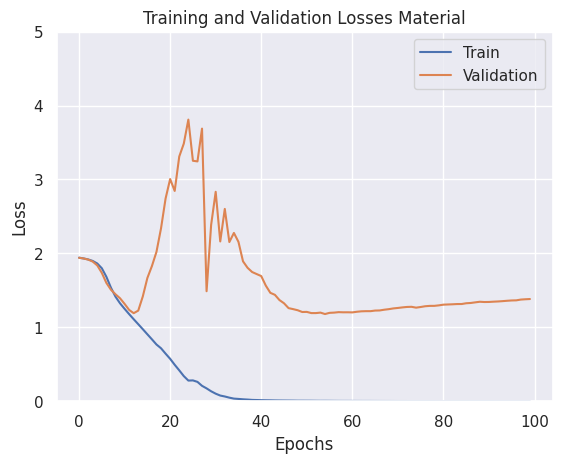

In [28]:
from datetime import datetime
import pytz
def ShowTrainLoss(train_losses,val_losses,save):
    # 日本時間のタイムゾーンを取得
    jst = pytz.timezone('Asia/Tokyo')

    # 現在の日本時間を取得
    now = datetime.now(jst)

    # 時刻を指定された形式の文字列に変換
    time = "_"+now.strftime("%Y%m%d%H%M")

    # 学習曲線の可視化

    title = 'Training and Validation Losses Material'
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0,5)
    plt.legend()
    if save == True:
        plt.savefig("data/"+title+time+".pdf")

    plt.show()

ShowTrainLoss(train_losses,val_losses,True)

In [29]:

# dim=1 で行ごとの最大値に対する要素番号を取得（dim=0 は列ごと）
y_label = torch.argmax(y[0], dim=1)
# 予測値から最大となるクラスの番号を取り出した結果
y_label
# 目的変数
t
# 値が一致しているか確認
y_label == t
# int => float 
torch.sum(y_label == t) * 1.0
# 正解率
acc = torch.sum(y_label == t) * 1.0 / len(t)
acc


# 正解率の計算
def calc_acc(data_loader):
    
    with torch.no_grad():
        
        accs = [] # 各バッチごとの結果格納用
        
        for batch in data_loader:
            x, t = batch
            
            # x = torch.unsqueeze(x,1)
            
            x = x.to(device)
            t = t.to(device)
            y = net2(x)
            
            y_label = torch.argmax(y[0], dim=1)
            acc = torch.sum(y_label == t) * 1.0 / len(t)
            accs.append(acc)
            
    # 全体の平均を算出
    avg_acc = torch.tensor(accs).mean()
    print('Accuracy: {:.1f}%'.format(avg_acc * 100))
    
    return avg_acc
      
# 検証データで確認
calc_acc(val_loader)
# テストデータで確認
calc_acc(test_loader)

Accuracy: 76.8%
Accuracy: 72.0%


tensor(0.7200)

### object 1

In [30]:
# tensorDatasetの作成
label_num = 0
train = torch.utils.data.TensorDataset(train_feature, train_labels[:,label_num])
val = torch.utils.data.TensorDataset(val_feature, val_labels[:,label_num])
test = torch.utils.data.TensorDataset(test_feature, test_labels[:,label_num])

# データローダに読み込む

# バッチサイズ
batch_size = 25

# shuffle はデフォルトで False のため、学習データのみ True に指定
train_loader = torch.utils.data.DataLoader(train, batch_size)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

for batch in train_loader:
    print(batch)

[tensor([[[[-18.6449, -11.7246,  -6.5343,  ..., -11.9112, -15.4409, -18.4369],
          [-14.1433,  -8.6324,  -6.4371,  ...,  -9.5212, -13.2930, -17.3637],
          [-17.4376, -17.0584, -18.9777,  ..., -17.6915, -19.0179, -18.6800],
          ...,
          [-53.1124, -51.7137, -51.1311,  ..., -51.2993, -51.5490, -53.4112],
          [-56.2612, -53.3037, -53.0943,  ..., -50.5234, -50.8584, -54.4903],
          [-55.8219, -52.3756, -51.8694,  ..., -52.8145, -52.2957, -52.7583]]],


        [[[-13.9764,  -8.9048,  -5.3486,  ...,  -0.4879,   0.0000,  -3.3279],
          [-18.0149,  -9.1427,  -5.1173,  ...,  -3.1938,  -1.3744,  -3.8136],
          [-29.0665, -17.4435, -14.8924,  ..., -16.7759, -15.4157, -12.8940],
          ...,
          [-54.9681, -50.0708, -50.2818,  ..., -50.2125, -50.9931, -53.4501],
          [-56.0666, -50.7504, -50.2297,  ..., -51.7665, -51.2975, -53.3952],
          [-53.6472, -50.9079, -52.0095,  ..., -50.7171, -50.7903, -52.6510]]],


        [[[-19.0949, -17.

In [31]:
objModel = matModel_trained

#パラメータの更新を許可
for param in objModel.parameters():
    param.requires_gred = True


# print(model.classifier)

# 出力層の最後だけ変更
# model.classifier[5] = torch.nn.Linear(1280,2)
objModel.classifier= nn.Sequential(
    nn.AdaptiveAvgPool2d(output_size=1),
    nn.Flatten(start_dim=1, end_dim=-1),
    nn.Linear(in_features=960, out_features=1280, bias=True),
    nn.Hardswish(),
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=527, bias=True),
    nn.BatchNorm1d(527),
    nn.Linear(in_features=527, out_features=21, bias=True),  # 新しい層
)
print(objModel)

DyMN(
  (layers): ModuleList(
    (0): DY_Block(
      (exp_conv): DynamicWrapper(
        (module): Identity()
      )
      (exp_norm): Identity()
      (exp_act): DynamicWrapper(
        (module): Identity()
      )
      (depth_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (depth_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (depth_act): DyReLUB(
        (coef_net): Sequential(
          (0): Linear(in_features=32, out_features=64, bias=True)
        )
        (sigmoid): Sigmoid()
      )
      (ca): CoordAtt()
      (proj_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (proj_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (context_gen): ContextGen(
        (joint_conv): Conv2d(16, 32, kernel_size=(1, 1

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

# エポックの数
max_epoch = 150
     
# モデルの初期化
torch.manual_seed(0)

# GPU の設定状況に基づいたデバイスの選択
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
# モデルのインスタンス化とデバイスへの転送
net3 = objModel.cuda()

criterion = F.cross_entropy
  
# 最適化手法の選択
optimizer = torch.optim.SGD(net3.parameters(), lr=0.1)
# エポックごとの訓練データの損失と検証データの損失を保存するリスト
train_losses = []
val_losses = []

# 学習ループ
for epoch in range(max_epoch):
    train_epoch_loss = 0.0
    val_epoch_loss = 0.0
    
    # 訓練データでの学習
    net3.train()
    for batch in train_loader:
        x, t = batch
        x = x.to(device)
        t = t.to(device)
        optimizer.zero_grad()
        y = net3(x)
        loss = criterion(y[0], t)
        train_epoch_loss += loss.item()  # エポック全体の訓練データの損失に加算
        loss.backward()
        optimizer.step()
    
    # 訓練データでのエポックごとの平均損失を計算し保存
    train_epoch_loss /= len(train_loader)
    train_losses.append(train_epoch_loss)
    
    # 検証データでの評価
    net3.eval()
    with torch.no_grad():
        for batch in val_loader:
            x, t = batch
  
            x = x.to(device)
            t = t.to(device)
            y = net3(x)
            loss = criterion(y[0], t)
            val_epoch_loss += loss.item()  # エポック全体の検証データの損失に加算
       
    # 検証データでのエポックごとの平均損失を計算し保存
    val_epoch_loss /= len(val_loader)
    val_losses.append(val_epoch_loss)
    
    # エポックごとに損失を表示
    print(f'Epoch [{epoch+1}/{max_epoch}], Train Loss: {train_epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}')


objModel_trained = net3


cuda:0
Epoch [1/150], Train Loss: 3.3798, Validation Loss: 4.2066
Epoch [2/150], Train Loss: 2.2056, Validation Loss: 7.1244
Epoch [3/150], Train Loss: 1.4317, Validation Loss: 5.7858
Epoch [4/150], Train Loss: 0.7432, Validation Loss: 3.1598
Epoch [5/150], Train Loss: 0.2514, Validation Loss: 1.7669
Epoch [6/150], Train Loss: 0.1268, Validation Loss: 1.2399
Epoch [7/150], Train Loss: 0.0411, Validation Loss: 0.9842
Epoch [8/150], Train Loss: 0.0187, Validation Loss: 0.9432
Epoch [9/150], Train Loss: 0.0105, Validation Loss: 0.8632
Epoch [10/150], Train Loss: 0.0065, Validation Loss: 0.8153
Epoch [11/150], Train Loss: 0.0059, Validation Loss: 0.7749
Epoch [12/150], Train Loss: 0.0051, Validation Loss: 0.7403
Epoch [13/150], Train Loss: 0.0047, Validation Loss: 0.7287
Epoch [14/150], Train Loss: 0.0040, Validation Loss: 0.7090
Epoch [15/150], Train Loss: 0.0033, Validation Loss: 0.7047
Epoch [16/150], Train Loss: 0.0030, Validation Loss: 0.7097
Epoch [17/150], Train Loss: 0.0027, Valida

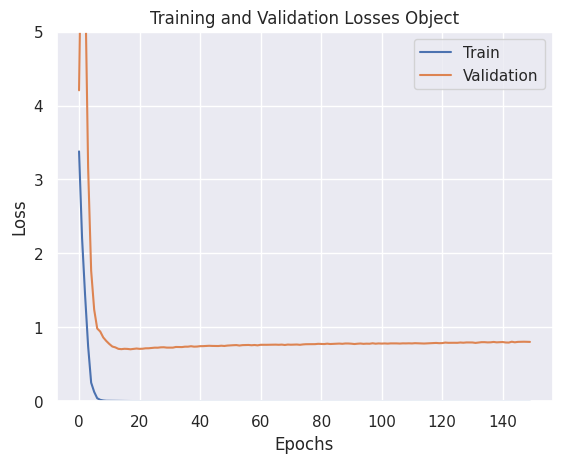

In [33]:
from datetime import datetime
import pytz
def ShowTrainLoss(train_losses,val_losses,save):
    # 日本時間のタイムゾーンを取得
    jst = pytz.timezone('Asia/Tokyo')

    # 現在の日本時間を取得
    now = datetime.now(jst)

    # 時刻を指定された形式の文字列に変換
    time = "_"+now.strftime("%Y%m%d%H%M")

    # 学習曲線の可視化

    title = 'Training and Validation Losses Object'
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0,5)
    plt.legend()
    if save == True:
        plt.savefig("data/"+title+time+".pdf")

    plt.show()

ShowTrainLoss(train_losses,val_losses,True)

In [34]:

# dim=1 で行ごとの最大値に対する要素番号を取得（dim=0 は列ごと）
y_label = torch.argmax(y[0], dim=1)
# 予測値から最大となるクラスの番号を取り出した結果
y_label
# 目的変数
t
# 値が一致しているか確認
y_label == t
# int => float 
torch.sum(y_label == t) * 1.0
# 正解率
acc = torch.sum(y_label == t) * 1.0 / len(t)
acc


# 正解率の計算
def calc_acc(data_loader):
    
    with torch.no_grad():
        
        accs = [] # 各バッチごとの結果格納用
        
        for batch in data_loader:
            x, t = batch
            
            # x = torch.unsqueeze(x,1)
            
            x = x.to(device)
            t = t.to(device)
            y = net3(x)
            
            y_label = torch.argmax(y[0], dim=1)
            acc = torch.sum(y_label == t) * 1.0 / len(t)
            accs.append(acc)
            
    # 全体の平均を算出
    avg_acc = torch.tensor(accs).mean()
    print('Accuracy: {:.1f}%'.format(avg_acc * 100))
    
    return avg_acc
      
# 検証データで確認
calc_acc(val_loader)
# テストデータで確認
calc_acc(test_loader)

Accuracy: 82.4%
Accuracy: 82.9%


tensor(0.8289)

### soft-hard 2

In [35]:
# tensorDatasetの作成
label_num = 2
train = torch.utils.data.TensorDataset(train_feature, train_labels[:,label_num])
val = torch.utils.data.TensorDataset(val_feature, val_labels[:,label_num])
test = torch.utils.data.TensorDataset(test_feature, test_labels[:,label_num])

# データローダに読み込む

# バッチサイズ
batch_size = 25

# shuffle はデフォルトで False のため、学習データのみ True に指定
train_loader = torch.utils.data.DataLoader(train, batch_size)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

for batch in train_loader:
    print(batch)

[tensor([[[[-18.6449, -11.7246,  -6.5343,  ..., -11.9112, -15.4409, -18.4369],
          [-14.1433,  -8.6324,  -6.4371,  ...,  -9.5212, -13.2930, -17.3637],
          [-17.4376, -17.0584, -18.9777,  ..., -17.6915, -19.0179, -18.6800],
          ...,
          [-53.1124, -51.7137, -51.1311,  ..., -51.2993, -51.5490, -53.4112],
          [-56.2612, -53.3037, -53.0943,  ..., -50.5234, -50.8584, -54.4903],
          [-55.8219, -52.3756, -51.8694,  ..., -52.8145, -52.2957, -52.7583]]],


        [[[-13.9764,  -8.9048,  -5.3486,  ...,  -0.4879,   0.0000,  -3.3279],
          [-18.0149,  -9.1427,  -5.1173,  ...,  -3.1938,  -1.3744,  -3.8136],
          [-29.0665, -17.4435, -14.8924,  ..., -16.7759, -15.4157, -12.8940],
          ...,
          [-54.9681, -50.0708, -50.2818,  ..., -50.2125, -50.9931, -53.4501],
          [-56.0666, -50.7504, -50.2297,  ..., -51.7665, -51.2975, -53.3952],
          [-53.6472, -50.9079, -52.0095,  ..., -50.7171, -50.7903, -52.6510]]],


        [[[-19.0949, -17.

In [36]:
shModel_2 = objModel_trained

#パラメータの更新を許可
for param in shModel_2.parameters():
    param.requires_gred = False


# print(model.classifier)

# 出力層の最後だけ変更
# model.classifier[5] = torch.nn.Linear(1280,2)
shModel_2.classifier= nn.Sequential(
    nn.AdaptiveAvgPool2d(output_size=1),
    nn.Flatten(start_dim=1, end_dim=-1),
    nn.Linear(in_features=960, out_features=1280, bias=False),
    nn.Hardswish(),
    nn.Dropout(p=0.2, inplace=False),
    nn.Linear(in_features=1280, out_features=527, bias=False),
    nn.ReLU(),
    nn.Linear(in_features=527, out_features=176, bias=True),  # 新しい層
    nn.ReLU(),
    nn.Linear(in_features=176, out_features=88, bias=True),  # 新しい層
    nn.ReLU(),
    nn.Linear(in_features=88, out_features=21, bias=True),  # 新しい層  
    nn.ReLU(),
    nn.Linear(in_features=21, out_features=2, bias=True),  # 新しい層  
)
print(shModel_2)

DyMN(
  (layers): ModuleList(
    (0): DY_Block(
      (exp_conv): DynamicWrapper(
        (module): Identity()
      )
      (exp_norm): Identity()
      (exp_act): DynamicWrapper(
        (module): Identity()
      )
      (depth_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (depth_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (depth_act): DyReLUB(
        (coef_net): Sequential(
          (0): Linear(in_features=32, out_features=64, bias=True)
        )
        (sigmoid): Sigmoid()
      )
      (ca): CoordAtt()
      (proj_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (proj_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (context_gen): ContextGen(
        (joint_conv): Conv2d(16, 32, kernel_size=(1, 1

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

# エポックの数
max_epoch = 50
     
# モデルの初期化
torch.manual_seed(0)

# GPU の設定状況に基づいたデバイスの選択
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
# モデルのインスタンス化とデバイスへの転送
net4 = shModel_2.cuda()

criterion = F.cross_entropy
  
# 最適化手法の選択
optimizer = torch.optim.SGD(net4.parameters(), lr=0.1)
# エポックごとの訓練データの損失と検証データの損失を保存するリスト
train_losses = []
val_losses = []

# 学習ループ
for epoch in range(max_epoch):
    train_epoch_loss = 0.0
    val_epoch_loss = 0.0
    
    # 訓練データでの学習
    net4.train()
    for batch in train_loader:
        x, t = batch
        x = x.to(device)
        t = t.to(device)
        optimizer.zero_grad()
        y = net4(x)
        loss = criterion(y[0], t)
        train_epoch_loss += loss.item()  # エポック全体の訓練データの損失に加算
        loss.backward()
        optimizer.step()
    
    # 訓練データでのエポックごとの平均損失を計算し保存
    train_epoch_loss /= len(train_loader)
    train_losses.append(train_epoch_loss)
    
    # 検証データでの評価
    net4.eval()
    with torch.no_grad():
        for batch in val_loader:
            x, t = batch
  
            x = x.to(device)
            t = t.to(device)
            y = net4(x)
            loss = criterion(y[0], t)
            val_epoch_loss += loss.item()  # エポック全体の検証データの損失に加算
       
    # 検証データでのエポックごとの平均損失を計算し保存
    val_epoch_loss /= len(val_loader)
    val_losses.append(val_epoch_loss)
    
    # エポックごとに損失を表示
    print(f'Epoch [{epoch+1}/{max_epoch}], Train Loss: {train_epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}')

shModel_2_trained = net4


cuda:0
Epoch [1/50], Train Loss: 0.6893, Validation Loss: 0.6854
Epoch [2/50], Train Loss: 0.6877, Validation Loss: 0.6846
Epoch [3/50], Train Loss: 0.6874, Validation Loss: 0.6845
Epoch [4/50], Train Loss: 0.6873, Validation Loss: 0.6844
Epoch [5/50], Train Loss: 0.6872, Validation Loss: 0.6843
Epoch [6/50], Train Loss: 0.6871, Validation Loss: 0.6842
Epoch [7/50], Train Loss: 0.6870, Validation Loss: 0.6841
Epoch [8/50], Train Loss: 0.6868, Validation Loss: 0.6840
Epoch [9/50], Train Loss: 0.6867, Validation Loss: 0.6838
Epoch [10/50], Train Loss: 0.6864, Validation Loss: 0.6835
Epoch [11/50], Train Loss: 0.6861, Validation Loss: 0.6831
Epoch [12/50], Train Loss: 0.6856, Validation Loss: 0.6826
Epoch [13/50], Train Loss: 0.6851, Validation Loss: 0.6820
Epoch [14/50], Train Loss: 0.6842, Validation Loss: 0.6810
Epoch [15/50], Train Loss: 0.6829, Validation Loss: 0.6794
Epoch [16/50], Train Loss: 0.6807, Validation Loss: 0.6767
Epoch [17/50], Train Loss: 0.6764, Validation Loss: 0.6709

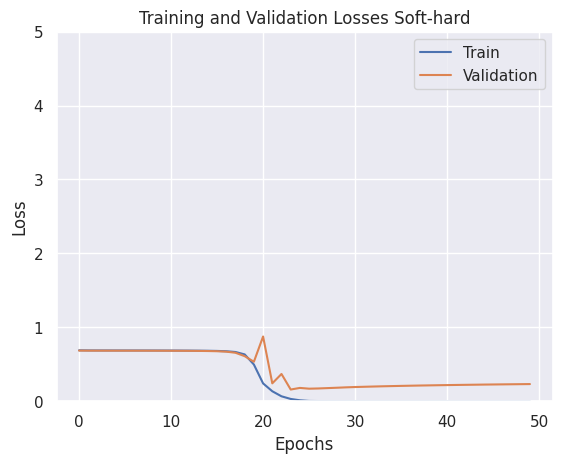

In [38]:
from datetime import datetime
import pytz
def ShowTrainLoss(train_losses,val_losses,save):
    # 日本時間のタイムゾーンを取得
    jst = pytz.timezone('Asia/Tokyo')

    # 現在の日本時間を取得
    now = datetime.now(jst)

    # 時刻を指定された形式の文字列に変換
    time = "_"+now.strftime("%Y%m%d%H%M")

    # 学習曲線の可視化

    title = 'Training and Validation Losses Soft-hard'
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0,5)
    plt.legend()
    if save == True:
        plt.savefig("data/"+title+time+".pdf")

    plt.show()

ShowTrainLoss(train_losses,val_losses,False)

In [39]:
# 正解率の計算
def calc_acc(data_loader):
    
    with torch.no_grad():
        
        accs = [] # 各バッチごとの結果格納用
        
        for batch in data_loader:
            x, t = batch
            
            # x = torch.unsqueeze(x,1)
            
            x = x.to(device)
            t = t.to(device)
            y = net4(x)
            
            y_label = torch.argmax(y[0], dim=1)
            acc = torch.sum(y_label == t) * 1.0 / len(t)
            accs.append(acc)
            
    # 全体の平均を算出
    avg_acc = torch.tensor(accs).mean()
    print('Accuracy: {:.1f}%'.format(avg_acc * 100))
    
    return avg_acc
      
# 検証データで確認
calc_acc(val_loader)
# テストデータで確認
calc_acc(test_loader)


Accuracy: 95.6%
Accuracy: 94.0%


tensor(0.9400)

### material 2

In [52]:
# tensorDatasetの作成
label_num = 1
train = torch.utils.data.TensorDataset(train_feature, train_labels[:,label_num])
val = torch.utils.data.TensorDataset(val_feature, val_labels[:,label_num])
test = torch.utils.data.TensorDataset(test_feature, test_labels[:,label_num])

# データローダに読み込む

# バッチサイズ
batch_size = 25

# shuffle はデフォルトで False のため、学習データのみ True に指定
train_loader = torch.utils.data.DataLoader(train, batch_size)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

for batch in train_loader:
    print(batch)

[tensor([[[[-18.6449, -11.7246,  -6.5343,  ..., -11.9112, -15.4409, -18.4369],
          [-14.1433,  -8.6324,  -6.4371,  ...,  -9.5212, -13.2930, -17.3637],
          [-17.4376, -17.0584, -18.9777,  ..., -17.6915, -19.0179, -18.6800],
          ...,
          [-53.1124, -51.7137, -51.1311,  ..., -51.2993, -51.5490, -53.4112],
          [-56.2612, -53.3037, -53.0943,  ..., -50.5234, -50.8584, -54.4903],
          [-55.8219, -52.3756, -51.8694,  ..., -52.8145, -52.2957, -52.7583]]],


        [[[-13.9764,  -8.9048,  -5.3486,  ...,  -0.4879,   0.0000,  -3.3279],
          [-18.0149,  -9.1427,  -5.1173,  ...,  -3.1938,  -1.3744,  -3.8136],
          [-29.0665, -17.4435, -14.8924,  ..., -16.7759, -15.4157, -12.8940],
          ...,
          [-54.9681, -50.0708, -50.2818,  ..., -50.2125, -50.9931, -53.4501],
          [-56.0666, -50.7504, -50.2297,  ..., -51.7665, -51.2975, -53.3952],
          [-53.6472, -50.9079, -52.0095,  ..., -50.7171, -50.7903, -52.6510]]],


        [[[-19.0949, -17.

In [41]:
matModel_2 = shModel_2_trained

#パラメータの更新を許可
for param in matModel_2.parameters():
    param.requires_gred = False


# print(model.classifier)

# 出力層の最後だけ変更
# model.classifier[5] = torch.nn.Linear(1280,2)
matModel_2.classifier= nn.Sequential(
    nn.AdaptiveAvgPool2d(output_size=1),
    nn.Flatten(start_dim=1, end_dim=-1),
    nn.Linear(in_features=960, out_features=1280, bias=False),
    nn.Hardswish(),
    nn.Dropout(p=0.2, inplace=False),
    nn.Linear(in_features=1280, out_features=527, bias=False),
    nn.ReLU(),
    nn.Linear(in_features=527, out_features=176, bias=False),  # 新しい層
    nn.ReLU(),
    nn.Linear(in_features=176, out_features=88, bias=True),  # 新しい層
    nn.ReLU(),
    nn.Linear(in_features=88, out_features=21, bias=True),  # 新しい層  
    nn.ReLU(),
    nn.Linear(in_features=21, out_features=7, bias=True),  # 新しい層   

)
print(shModel_2)

DyMN(
  (layers): ModuleList(
    (0): DY_Block(
      (exp_conv): DynamicWrapper(
        (module): Identity()
      )
      (exp_norm): Identity()
      (exp_act): DynamicWrapper(
        (module): Identity()
      )
      (depth_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (depth_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (depth_act): DyReLUB(
        (coef_net): Sequential(
          (0): Linear(in_features=32, out_features=64, bias=True)
        )
        (sigmoid): Sigmoid()
      )
      (ca): CoordAtt()
      (proj_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (proj_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (context_gen): ContextGen(
        (joint_conv): Conv2d(16, 32, kernel_size=(1, 1

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

# エポックの数
epoch = 0
max_epoch = 300     
# モデルの初期化
torch.manual_seed(0)

# GPU の設定状況に基づいたデバイスの選択
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
# モデルのインスタンス化とデバイスへの転送
net5 = matModel_2.cuda()

criterion = F.cross_entropy
  
# 最適化手法の選択
optimizer = torch.optim.SGD(net5.parameters(), lr=0.1)
# エポックごとの訓練データの損失と検証データの損失を保存するリスト
train_losses = []
val_losses = []

# 学習ループ
# for epoch in range(max_epoch):
train_epoch_loss = 1.0
val_epoch_loss = 1.0

while (train_epoch_loss > 0.1 or val_epoch_loss  > 0.8) and epoch<max_epoch:
    train_epoch_loss = 0.0
    val_epoch_loss = 0.0
    
    # 訓練データでの学習
    net5.train()
    for batch in train_loader:
        x, t = batch
        x = x.to(device)
        t = t.to(device)
        optimizer.zero_grad()
        y = net5(x)
        loss = criterion(y[0], t)
        train_epoch_loss += loss.item()  # エポック全体の訓練データの損失に加算
        loss.backward()
        optimizer.step()
    
    # 訓練データでのエポックごとの平均損失を計算し保存
    train_epoch_loss /= len(train_loader)
    train_losses.append(train_epoch_loss)
    
    # 検証データでの評価
    net5.eval()
    with torch.no_grad():
        for batch in val_loader:
            x, t = batch
  
            x = x.to(device)
            t = t.to(device)
            y = net5(x)
            loss = criterion(y[0], t)
            val_epoch_loss += loss.item()  # エポック全体の検証データの損失に加算
       
    # 検証データでのエポックごとの平均損失を計算し保存
    val_epoch_loss /= len(val_loader)
    val_losses.append(val_epoch_loss)
    
    # エポックごとに損失を表示
    print(f'Epoch [{epoch+1}/{max_epoch}], Train Loss: {train_epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}')
    epoch+=1

matModel_2_trained = net5


cuda:0
Epoch [1/300], Train Loss: 1.9575, Validation Loss: 1.9528
Epoch [2/300], Train Loss: 1.9516, Validation Loss: 1.9493
Epoch [3/300], Train Loss: 1.9492, Validation Loss: 1.9477
Epoch [4/300], Train Loss: 1.9481, Validation Loss: 1.9470
Epoch [5/300], Train Loss: 1.9476, Validation Loss: 1.9467
Epoch [6/300], Train Loss: 1.9474, Validation Loss: 1.9465
Epoch [7/300], Train Loss: 1.9472, Validation Loss: 1.9464
Epoch [8/300], Train Loss: 1.9471, Validation Loss: 1.9462
Epoch [9/300], Train Loss: 1.9469, Validation Loss: 1.9461
Epoch [10/300], Train Loss: 1.9468, Validation Loss: 1.9460
Epoch [11/300], Train Loss: 1.9466, Validation Loss: 1.9458
Epoch [12/300], Train Loss: 1.9465, Validation Loss: 1.9457
Epoch [13/300], Train Loss: 1.9463, Validation Loss: 1.9454
Epoch [14/300], Train Loss: 1.9461, Validation Loss: 1.9452
Epoch [15/300], Train Loss: 1.9458, Validation Loss: 1.9449
Epoch [16/300], Train Loss: 1.9455, Validation Loss: 1.9446
Epoch [17/300], Train Loss: 1.9451, Valida

In [43]:
matModel_2_trained = net5


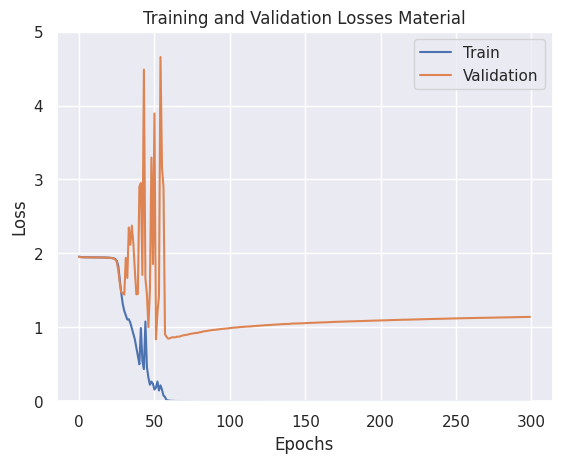

In [44]:
from datetime import datetime
import pytz
def ShowTrainLoss(train_losses,val_losses,save):
    # 日本時間のタイムゾーンを取得
    jst = pytz.timezone('Asia/Tokyo')

    # 現在の日本時間を取得
    now = datetime.now(jst)

    # 時刻を指定された形式の文字列に変換
    time = "_"+now.strftime("%Y%m%d%H%M")

    # 学習曲線の可視化

    title = 'Training and Validation Losses Material'
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0,5)
    plt.legend()
    if save == True:
        plt.savefig("data/"+title+time+".pdf")

    plt.show()

ShowTrainLoss(train_losses,val_losses,True)

In [45]:

# dim=1 で行ごとの最大値に対する要素番号を取得（dim=0 は列ごと）
y_label = torch.argmax(y[0], dim=1)
# 予測値から最大となるクラスの番号を取り出した結果
y_label
# 目的変数
t
# 値が一致しているか確認
y_label == t
# int => float 
torch.sum(y_label == t) * 1.0
# 正解率
acc = torch.sum(y_label == t) * 1.0 / len(t)
acc


# 正解率の計算
def calc_acc(data_loader):
    
    with torch.no_grad():
        
        accs = [] # 各バッチごとの結果格納用
        
        for batch in data_loader:
            x, t = batch
            
            # x = torch.unsqueeze(x,1)
            
            x = x.to(device)
            t = t.to(device)
            y = net5(x)
            
            y_label = torch.argmax(y[0], dim=1)
            acc = torch.sum(y_label == t) * 1.0 / len(t)
            accs.append(acc)
            
    # 全体の平均を算出
    avg_acc = torch.tensor(accs).mean()
    print('Accuracy: {:.1f}%'.format(avg_acc * 100))
    
    return avg_acc
      
# 検証データで確認
calc_acc(val_loader)
# テストデータで確認
calc_acc(test_loader)

Accuracy: 88.4%
Accuracy: 82.0%


tensor(0.8200)

### object 2

In [53]:
# tensorDatasetの作成
label_num = 0
train = torch.utils.data.TensorDataset(train_feature, train_labels[:,label_num])
val = torch.utils.data.TensorDataset(val_feature, val_labels[:,label_num])
test = torch.utils.data.TensorDataset(test_feature, test_labels[:,label_num])

# データローダに読み込む

# バッチサイズ
batch_size = 25

# shuffle はデフォルトで False のため、学習データのみ True に指定
train_loader = torch.utils.data.DataLoader(train, batch_size)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

for batch in train_loader:
    print(batch)

[tensor([[[[-18.6449, -11.7246,  -6.5343,  ..., -11.9112, -15.4409, -18.4369],
          [-14.1433,  -8.6324,  -6.4371,  ...,  -9.5212, -13.2930, -17.3637],
          [-17.4376, -17.0584, -18.9777,  ..., -17.6915, -19.0179, -18.6800],
          ...,
          [-53.1124, -51.7137, -51.1311,  ..., -51.2993, -51.5490, -53.4112],
          [-56.2612, -53.3037, -53.0943,  ..., -50.5234, -50.8584, -54.4903],
          [-55.8219, -52.3756, -51.8694,  ..., -52.8145, -52.2957, -52.7583]]],


        [[[-13.9764,  -8.9048,  -5.3486,  ...,  -0.4879,   0.0000,  -3.3279],
          [-18.0149,  -9.1427,  -5.1173,  ...,  -3.1938,  -1.3744,  -3.8136],
          [-29.0665, -17.4435, -14.8924,  ..., -16.7759, -15.4157, -12.8940],
          ...,
          [-54.9681, -50.0708, -50.2818,  ..., -50.2125, -50.9931, -53.4501],
          [-56.0666, -50.7504, -50.2297,  ..., -51.7665, -51.2975, -53.3952],
          [-53.6472, -50.9079, -52.0095,  ..., -50.7171, -50.7903, -52.6510]]],


        [[[-19.0949, -17.

In [54]:
objModel_2 = matModel_2_trained

# パラメータの更新を許可
for param in objModel_2.parameters():
    param.requires_grad =  False # requires_gred -> requires_grad

# 新しい層の追加とBatch Normalizationの導入
objModel_2.classifier = nn.Sequential(
    nn.AdaptiveAvgPool2d(output_size=1),
    nn.Flatten(start_dim=1, end_dim=-1),
    nn.Linear(in_features=960, out_features=1280, bias=True),
    nn.Hardswish(),
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=527, bias=True),
    nn.ReLU(),
    nn.Linear(in_features=527, out_features=176, bias=True),  # 新しい層
    nn.ReLU(),
    # nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=176, out_features=88, bias=True),  # 新しい層
    nn.ReLU(),
    nn.Linear(in_features=88, out_features=21, bias=True),  # 新しい層  
    # nn.Dropout(p=0.2, inplace=True),
    nn.ReLU(),
    nn.Linear(in_features=21, out_features=21, bias=True),  # 新しい層     
)

print(objModel_2)


DyMN(
  (layers): ModuleList(
    (0): DY_Block(
      (exp_conv): DynamicWrapper(
        (module): Identity()
      )
      (exp_norm): Identity()
      (exp_act): DynamicWrapper(
        (module): Identity()
      )
      (depth_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (depth_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (depth_act): DyReLUB(
        (coef_net): Sequential(
          (0): Linear(in_features=32, out_features=64, bias=True)
        )
        (sigmoid): Sigmoid()
      )
      (ca): CoordAtt()
      (proj_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (proj_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (context_gen): ContextGen(
        (joint_conv): Conv2d(16, 32, kernel_size=(1, 1

In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

# エポックの数
epoch = 0
max_epoch = 1000     
# モデルの初期化
torch.manual_seed(0)

# GPU の設定状況に基づいたデバイスの選択
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
# モデルのインスタンス化とデバイスへの転送
net6 = objModel_2.cuda()

criterion = F.cross_entropy
  
# 最適化手法の選択
optimizer = torch.optim.SGD(net6.parameters(), lr=0.1)
# エポックごとの訓練データの損失と検証データの損失を保存するリスト
train_losses = []
val_losses = []

train_epoch_loss = 1.0
val_epoch_loss = 1.0
# 学習ループ
while (train_epoch_loss > 0.1 or val_epoch_loss  > 0.88) and epoch<max_epoch:
    train_epoch_loss = 0.0
    val_epoch_loss = 0.0
    
    # 訓練データでの学習
    net6.train()
    for batch in train_loader:
        x, t = batch
        x = x.to(device)
        t = t.to(device)
        optimizer.zero_grad()
        y = net6(x)
        loss = criterion(y[0], t)
        train_epoch_loss += loss.item()  # エポック全体の訓練データの損失に加算
        loss.backward()
        optimizer.step()
    
    # 訓練データでのエポックごとの平均損失を計算し保存
    train_epoch_loss /= len(train_loader)
    train_losses.append(train_epoch_loss)
    
    # 検証データでの評価
    net6.eval()
    with torch.no_grad():
        for batch in val_loader:
            x, t = batch
  
            x = x.to(device)
            t = t.to(device)
            y = net6(x)
            loss = criterion(y[0], t)
            val_epoch_loss += loss.item()  # エポック全体の検証データの損失に加算
       
    # 検証データでのエポックごとの平均損失を計算し保存
    val_epoch_loss /= len(val_loader)
    val_losses.append(val_epoch_loss)
    
    # エポックごとに損失を表示
    print(f'Epoch [{epoch+1}/{max_epoch}], Train Loss: {train_epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}')
    epoch+=1

objModel_2_trained = net6


cuda:0
Epoch [1/1000], Train Loss: 3.0533, Validation Loss: 3.0550
Epoch [2/1000], Train Loss: 3.0510, Validation Loss: 3.0529
Epoch [3/1000], Train Loss: 3.0493, Validation Loss: 3.0513
Epoch [4/1000], Train Loss: 3.0480, Validation Loss: 3.0501
Epoch [5/1000], Train Loss: 3.0470, Validation Loss: 3.0491
Epoch [6/1000], Train Loss: 3.0462, Validation Loss: 3.0483
Epoch [7/1000], Train Loss: 3.0455, Validation Loss: 3.0476
Epoch [8/1000], Train Loss: 3.0449, Validation Loss: 3.0469
Epoch [9/1000], Train Loss: 3.0443, Validation Loss: 3.0463
Epoch [10/1000], Train Loss: 3.0438, Validation Loss: 3.0457
Epoch [11/1000], Train Loss: 3.0432, Validation Loss: 3.0451
Epoch [12/1000], Train Loss: 3.0425, Validation Loss: 3.0445
Epoch [13/1000], Train Loss: 3.0419, Validation Loss: 3.0437
Epoch [14/1000], Train Loss: 3.0410, Validation Loss: 3.0428
Epoch [15/1000], Train Loss: 3.0400, Validation Loss: 3.0417
Epoch [16/1000], Train Loss: 3.0386, Validation Loss: 3.0403
Epoch [17/1000], Train Los

In [56]:
objModel_2_trained = net6


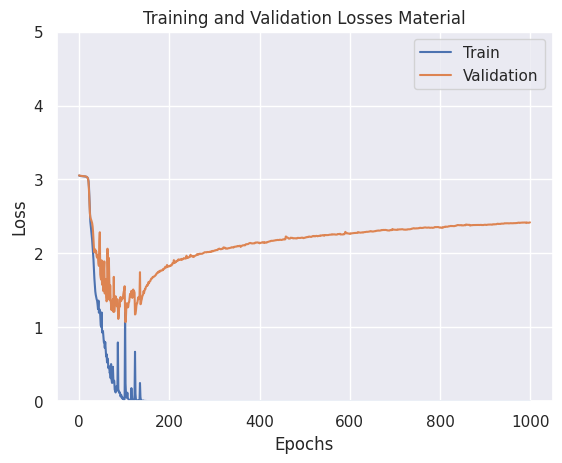

In [57]:
from datetime import datetime
import pytz
def ShowTrainLoss(train_losses,val_losses,save):
    # 日本時間のタイムゾーンを取得
    jst = pytz.timezone('Asia/Tokyo')

    # 現在の日本時間を取得
    now = datetime.now(jst)

    # 時刻を指定された形式の文字列に変換
    time = "_"+now.strftime("%Y%m%d%H%M")

    # 学習曲線の可視化

    title = 'Training and Validation Losses Material'
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0,5)
    plt.legend()
    if save == True:
        plt.savefig("data/"+title+time+".pdf")

    plt.show()

ShowTrainLoss(train_losses,val_losses,True)

In [58]:
# 正解率の計算
def calc_acc(data_loader):
    
    with torch.no_grad():
        
        accs = [] # 各バッチごとの結果格納用
        
        for batch in data_loader:
            x, t = batch
            
            # x = torch.unsqueeze(x,1)
            
            x = x.to(device)
            t = t.to(device)
            y = net6(x)
            
            y_label = torch.argmax(y[0], dim=1)
            acc = torch.sum(y_label == t) * 1.0 / len(t)
            accs.append(acc)
            
    # 全体の平均を算出
    avg_acc = torch.tensor(accs).mean()
    print('Accuracy: {:.1f}%'.format(avg_acc * 100))
    
    return avg_acc
      
# 検証データで確認
calc_acc(val_loader)
# テストデータで確認
calc_acc(test_loader)

Accuracy: 78.4%
Accuracy: 72.0%


tensor(0.7200)